In [160]:
import pickle
#import sklearn
#from sklearn import metrics
#from sklearn import linear_model
from sklearn.model_selection import train_test_split
import random
import numpy as np
#from wac import WAC
from tqdm.notebook import tqdm
import pandas as pd
#from sklearn import neural_network
#import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
from collections import defaultdict as dd
import nltk 
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/crow/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Initiate Datasets

In [2]:
wac2vec = pickle.load(open('ddata/clip.bertvocab.embeddings.513.pkl', 'rb'))
len(wac2vec)

30522

In [3]:
concr_scores = pickle.load(open('ddata/AC_ratings_google3m_koeper_SiW.pkl', 'rb'))
len(concr_scores)

2168990

## ConcreteAbstract Class

In [4]:
class ConcreteAbstract:
    def __init__(self, word_vectors, concr_scores, word_net):
        pass

### Build Abstraction Tree

In [5]:
import warnings

def init_abstraction_tree(min_rating=8):

    wac_words = list(wac2vec.keys())
    wn_words = set(i for i in wn.words())
    wn_wac_words = wn_words & set(wac_words)
    
    concr_scores_subset = concr_scores[concr_scores.RATING >= min_rating]
    leaf_words = [w for w in tqdm(wn_wac_words) if w in concr_scores_subset.index]

    # Get Leaf Synsets...
    leaf_synsets = [wn.synsets(w)[0] for w in leaf_words]

    # Initiate Abstraction Tree
    embeddings = [wac2vec[w] for w in leaf_words]
    data = {
        "SYNSET" : leaf_synsets,
        "WORD" : leaf_words,
        "DIST2LEAF": [0]*len(leaf_synsets),
        "NUM_LEAVES": [1]*len(leaf_synsets),
        "HYPERNYM": [[]]*len(leaf_synsets),
        "HYPONYMS": [[]]*len(leaf_synsets),
        "EMBEDDING" : embeddings
        
    }
    abstraction_tree = pd.DataFrame(data)
    abstraction_tree.index = abstraction_tree.SYNSET

    # Get True Leaf Synsets
    ancestors = set()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for s in leaf_synsets:
            #print(set(s.closure(lambda s: s.hypernyms())))
            ancestors = ancestors.union(set(s.closure(lambda s: s.hypernyms())))

    # Remove leaves that are ansestors of other leaves
    true_leaf_synsets = set(leaf_synsets) - ancestors
    ansestor_leaves = set(leaf_synsets) - true_leaf_synsets
    abstraction_tree.drop(ansestor_leaves, inplace=True)
    
    # Remove leaves that have the same Synset
    abstraction_tree.drop_duplicates(subset='SYNSET', inplace=True)
    
    return abstraction_tree

In [378]:
# Grow abstraction tree

def update_dist2leaf(synset, dist):
    h_dist = abstraction_tree.loc[synset, 'DIST2LEAF']
    if h_dist > dist:
        return
    
    abstraction_tree.at[synset, 'DIST2LEAF'] = dist
    
    # go up the hypernym chain and set the distances
    h = abstraction_tree.loc[synset, 'HYPERNYM']
    if len(h) != 0:
        update_dist2leaf(h[0], dist+1)
        

def update_num_leaves(synset, num_leaves):
    orig_num_leaves = abstraction_tree.loc[synset, 'NUM_LEAVES']
    abstraction_tree.at[synset, 'NUM_LEAVES'] = orig_num_leaves + num_leaves
    
    # go up the hypernym chain and update the leaves
    h = abstraction_tree.loc[synset, 'HYPERNYM']
    if len(h) != 0:
        update_num_leaves(h[0], num_leaves)

def grow_abstraction_tree(abstraction_tree):
    """Takes an initial abstraction tree (containing only leaves) and grows
    the rest of the tree."""
    
    synset_list = list(abstraction_tree['SYNSET'])

    for s in tqdm(synset_list):
        h = s.hypernyms()

        if len(h) == 0:
            continue

        h = h[0]

        if h not in abstraction_tree.SYNSET:
            synset_list.append(h)
            abstraction_tree.loc[h] = [
                h,    # SYNSET
                None, # WORD
                0,    # DIST2LEAF
                0,    # NUM_LEAVES
                [],   # HYPERNYM
                [],   # HYPONYMS
                None  # EMBEDDING
            ]

        # Set DIST2LEAF
        s_dist = abstraction_tree.loc[s, 'DIST2LEAF']
        update_dist2leaf(h, s_dist+1)
        #h_dist = abstraction_tree.loc[h, 'DIST2LEAF']
        #print(s)
        #if s_dist >= h_dist:
            #while abstraction_tree.loc[h, 'DIST2LEAF']
            #abstraction_tree.loc[h, 'DIST2LEAF'] = s_dist + 1

        # Set NUM_LEAVES
        s_num_leaves = abstraction_tree.loc[s, 'NUM_LEAVES']
        update_num_leaves(h, s_num_leaves)
        #h_num_leaves = abstraction_tree.loc[h, 'NUM_LEAVES']
        #abstraction_tree.loc[h, 'NUM_LEAVES'] = h_num_leaves + s_num_leaves

        # Add hypernym to synset
        abstraction_tree.loc[s, 'HYPERNYM'] = [h]

        # Add synset to hypernym
        abstraction_tree.loc[h, 'HYPONYMS'].append(s)

In [379]:
# Display abstraction tree
from nltk.tree import Tree

def build_display_tree(df, root_synset, char_limit=20):
    """Display an abstraction tree starting with the root_synset.
    Returns an nltk Tree structure.
    Do not use on big trees!"""
    row = df.loc[root_synset]
    root_name = row['SYNSET'].lemmas()[0].name()[:char_limit]
    if len(row['HYPONYMS']) == 0:
        return root_name
    
    children = [build_display_tree(df, h, char_limit) for h in row['HYPONYMS']]
    
    return Tree(root_name, children)

In [380]:
abstraction_tree = init_abstraction_tree(9)

  0%|          | 0/14510 [00:00<?, ?it/s]

In [381]:
#abstraction_tree.loc[wn.synset('chordate.n.01'), 'DIST2LEAF']


In [382]:
grow_abstraction_tree(abstraction_tree)

  0%|          | 0/17 [00:00<?, ?it/s]

In [383]:
#build_display_tree(abstraction_tree, wn.synset('entity.n.01'), char_limit=5)

In [384]:
# Get Positive Synsets

In [575]:
# Number of positive examples we want for each classifier
pos_count = 3
neg_count = 9

def is_leaf(synset):
    if synset not in abstraction_tree.index:
        return False
    return abstraction_tree.loc[synset, 'DIST2LEAF'] == 0

def classifier_capable(synset):
    return abstraction_tree.loc[synset, 'NUM_LEAVES'] >= pos_count

def is_embedding_capable(synset):
    """Return true if the synset is capable of having an embedding."""
    if synset not in abstraction_tree.index:
        return False
    return is_leaf(synset) or classifier_capable(synset)

# dist2leaf gives us the furthest leaf.
# This can be used as a "sort" of way to determine abstraction level
def dist2leaf(synset):
    return abstraction_tree.loc[synset, 'DIST2LEAF']

def is_closer_to_leaf(synset, dist):
    """Return true if the synset is closer to a leaf than dist."""
    return dist2leaf(synset) < dist

def get_hyponyms(synset):
    """Return a list of hyponyms, or itself if there are none."""
    if synset not in abstraction_tree.index:
        return None
    hypos = abstraction_tree.loc[synset, 'HYPONYMS']
    if len(hypos) == 0:
        return [synset]
    else:
        return hypos

def count_embedding_capable(synset_list):
    """Given a list of synsets, returns a count of how many are capable of having an embedding."""
    return sum((is_embedding_capable(s) == True)*1 for s in synset_list)

def expand_hyponym_list(synset_list):
    hypos = []
    for s in synset_list:
        hypos += get_hyponyms(s)
    return hypos

def remove_embedding_incapable(synset_list):
    synset_list = np.array(synset_list)
    return list(synset_list[list(map(is_embedding_capable, synset_list))])

def find_positive_examples(synset, depth=100):
    pos = get_hyponyms(synset)
    for _ in range(depth):
        pos = expand_hyponym_list(pos)
        if count_embedding_capable(pos) >= pos_count:
            return remove_embedding_incapable(pos)
    
    raise Exception("Reached depth of {} without finding enough positive example: {}".format(depth, synset))

In [576]:
find_positive_examples(wn.synset('artifact.n.01'))

[Synset('rug.n.01'), Synset('shoe.n.01'), Synset('watchband.n.01')]

In [465]:
# Find negative examples...

In [466]:
def find_negative_examples(synset, pos_examples):
    # All synsets
    neg = np.array(abstraction_tree['SYNSET'])
    # Embedding capable synsets
    neg = neg[list(map(is_embedding_capable, neg))]
    # Use only more concrete words (words that are closer to a leaf)
    dist2leaf = abstraction_tree.loc[synset, 'DIST2LEAF']
    neg = neg[list(map(lambda x: is_closer_to_leaf(x, dist2leaf), neg))]
    # neg examples not in positive examples
    neg = set(neg) - set(pos_examples)
    # Don't include yourself
    #neg.remove(synset) # removed by the closer check
    neg_examples = random.sample(list(neg), k=min(neg_count, len(neg)))
    return neg_examples

In [467]:
pos_examples = find_positive_examples(wn.synset('entity.n.01'))

In [468]:
neg_examples = find_negative_examples(wn.synset('entity.n.01'), pos_examples)

In [469]:
neg_examples

[Synset('vertebrate.n.01'),
 Synset('shark.n.01'),
 Synset('living_thing.n.01'),
 Synset('frog.n.01'),
 Synset('gorilla.n.01'),
 Synset('covering.n.02'),
 Synset('chordate.n.01'),
 Synset('brassiere.n.01'),
 Synset('pizza.n.01')]

In [470]:
def add_positive_negative_examples(synset):
    pos = find_positive_examples(synset)
    abstraction_tree.at[synset, 'POSITIVE'] = pos
    neg = find_negative_examples(synset, pos)
    abstraction_tree.at[synset, 'NEGATIVE'] = neg

In [471]:
def get_classifier_capable():
    """Get a list of synsets capable of having a classifier."""
    return [s for s in abstraction_tree['SYNSET'] if classifier_capable(s)]

In [472]:
def add_pos_neg_all():
    """Add positive and negative examples for each calssifier capable synset."""
    abstraction_tree['POSITIVE'] = [[]]*len(abstraction_tree)
    abstraction_tree['NEGATIVE'] = [[]]*len(abstraction_tree)
    for s in get_classifier_capable():
        add_positive_negative_examples(s)

In [578]:
add_pos_neg_all()

In [474]:
# Build Train/Test datasets

In [475]:
def build_train_test(synset):
    pos_examples = find_positive_examples(synset)
    neg_examples = find_negative_examples(synset, pos_examples)
    X = pos_examples + neg_examples
    y = list(np.ones(len(pos_examples))) + list(np.zeros(len(neg_examples)))
    return train_test_split(X, y, test_size=0.33, stratify=y)

In [476]:
def fill_out_train_test():
    abstraction_tree['X_TRAIN'] = [[]]*len(abstraction_tree)
    abstraction_tree['X_TEST']  = [[]]*len(abstraction_tree)
    abstraction_tree['Y_TRAIN'] = [[]]*len(abstraction_tree)
    abstraction_tree['Y_TEST']  = [[]]*len(abstraction_tree)
    
    synsets = get_classifier_capable()
    for s in synsets:
        X_train, X_test, y_train, y_test  = build_train_test(s)
        abstraction_tree.at[s, 'X_TRAIN'] = X_train
        abstraction_tree.at[s, 'X_TEST']  = X_test
        abstraction_tree.at[s, 'Y_TRAIN'] = y_train
        abstraction_tree.at[s, 'Y_TEST']  = y_test        

In [579]:
fill_out_train_test()

In [478]:
# Train...

In [624]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [582]:
def coefs(classifier):
    return classifier.coef_[0]

def build_classifiers():
    abstraction_tree['CLASSIFIER']  = [None]*len(abstraction_tree)
    cc = get_classifier_capable()
    # Start with synsets close to leaves and work our way up to more abstract hypernyms
    cc.sort(key=dist2leaf)
    for ss in cc:
        #print(ss)
        X_train = abstraction_tree.loc[ss, 'X_TRAIN']
        y_train = abstraction_tree.loc[ss, 'Y_TRAIN']
        X_train = list(abstraction_tree.loc[X_train, 'EMBEDDING'])
        lr = LogisticRegression()
        lr.fit(X_train, y_train)
        abstraction_tree.at[ss, 'CLASSIFIER'] = lr
        abstraction_tree.at[ss, 'EMBEDDING'] = coefs(lr)
       
        

In [583]:
build_classifiers()

In [584]:
abstraction_tree.loc[get_classifier_capable(), 'EMBEDDING']

SYNSET
Synset('covering.n.02')           [-0.09218192162954708, -0.0842081314877646, -0...
Synset('vertebrate.n.01')         [0.06667088576489986, -0.051623577590078254, -...
Synset('artifact.n.01')           [0.00952026672169675, -0.050406195948416326, 0...
Synset('chordate.n.01')           [0.03989486294173795, 0.009056084318817778, -0...
Synset('matter.n.03')             [-0.10002663098540066, 0.06025830475134483, 0....
Synset('whole.n.02')              [-0.042492902859213484, -0.07450487439164102, ...
Synset('animal.n.01')             [0.0005626203294571935, 0.0517113383249512, -0...
Synset('physical_entity.n.01')    [0.019399456564682473, 0.15229244445591747, 0....
Synset('object.n.01')             [-0.05096466822027962, -0.060005630136257364, ...
Synset('organism.n.01')           [0.003570897249934439, -0.06588628231136748, 0...
Synset('entity.n.01')             [0.019162959986055533, 0.05561240987041495, 0....
Synset('living_thing.n.01')       [0.01779918851703777, 0.01106452924

In [648]:
# Random Baseline (For a single classifier)

In [649]:
def calc_random_baseline():
    pos, tot = 0, 0
    for ss in get_classifier_capable():
        y = abstraction_tree.loc[ss, 'Y_TRAIN']
        pos += sum(y)
        tot += len(y)
        y = abstraction_tree.loc[ss, 'Y_TEST']
        pos += sum(y)
        tot += len(y)
    return pos/tot

In [650]:
calc_random_baseline()

0.2602739726027397

In [652]:
# Most Common Baseline (For a single classifier)

In [651]:
1-calc_random_baseline()

0.7397260273972603

In [589]:
# Evaluate (vs negative examples)

In [659]:
def evaluate_classifiers():
    golds = []
    preds = []
    for ss in get_classifier_capable():
        X_test = abstraction_tree.loc[ss, 'X_TEST']
        y_test = abstraction_tree.loc[ss, 'Y_TEST']
        X_test = list(abstraction_tree.loc[X_test, 'EMBEDDING'])
        
        c = abstraction_tree.loc[ss, 'CLASSIFIER']
        pred = c.predict_proba(X_test)
        #pred = lr.predict_proba(X_test)
        pred = np.argmax(pred, axis=1)
        #print(list(map(int, y_test)))
        #print(list(pred))
        #print()
        preds = list(preds) + list(pred)
        golds = golds + y_test
    return metrics.accuracy_score(golds, preds)

In [660]:
evaluate_classifiers()

0.74

In [590]:
# Evaluate (vs distractors)

In [596]:
ss = cc[1]

In [597]:
ss

Synset('artifact.n.01')

In [598]:
abstraction_tree.loc[ss, 'X_TRAIN']

[Synset('beetle.n.01'),
 Synset('watchband.n.01'),
 Synset('eyelid.n.01'),
 Synset('bandage.n.01'),
 Synset('sausage.n.01'),
 Synset('shark.n.01'),
 Synset('rug.n.01'),
 Synset('cereal.n.01')]

In [599]:
X_train = abstraction_tree.loc[ss, 'X_TRAIN']
y_train = abstraction_tree.loc[ss, 'Y_TRAIN']
X_train = list(abstraction_tree.loc[X_train, 'EMBEDDING'])

In [600]:
lr = LogisticRegression()

In [601]:
X_train

[array([-5.56509905e-02, -1.42573696e-02, -2.55136844e-03, -1.08938612e-01,
         1.19765932e-02,  2.33328491e-01, -7.11649582e-02,  8.38447511e-02,
         1.39175341e-01, -2.24807099e-01,  1.45076141e-01,  2.46770695e-01,
         3.35451737e-02,  1.02050476e-01,  1.01365469e-01,  8.07087049e-02,
        -2.09817626e-02,  6.37872517e-02,  1.93294585e-02,  3.50273162e-01,
         1.31169841e-01,  3.68288644e-02, -8.71918201e-02,  1.60244301e-01,
        -1.60957262e-01, -3.28634903e-02, -1.72263205e-01, -1.31379351e-01,
        -9.74020958e-02, -1.12878621e-01, -8.96234140e-02, -1.31225437e-01,
        -3.93405885e-01, -2.01108798e-01, -2.20204949e-01,  4.67521437e-02,
        -4.23942506e-02, -9.55785513e-02,  4.59006540e-02, -1.18948273e-01,
         9.56026688e-02,  1.23319641e-01, -1.42606810e-01, -1.90571457e-01,
         1.24795839e-01, -2.89636433e-01, -6.18021972e-02, -1.80188313e-01,
        -1.90759599e-01,  2.27093115e-01,  9.93048921e-02,  5.57411946e-02,
        -1.1

In [602]:
lr.fit(X_train, y_train)

LogisticRegression()

In [603]:
X_test = abstraction_tree.loc[ss, 'X_TEST']
y_test = abstraction_tree.loc[ss, 'Y_TEST']
X_test = list(abstraction_tree.loc[X_test, 'EMBEDDING'])

In [605]:
pred = lr.predict_proba(X_test)

In [611]:
pred[1] = [.2, .6]

In [612]:
np.argmax(pred, axis=1)

array([0, 1, 0, 0])

In [609]:
lr.predict_proba(X_test)

array([[0.78926635, 0.21073365],
       [0.86064539, 0.13935461],
       [0.87110672, 0.12889328],
       [0.826131  , 0.173869  ]])

In [533]:
y_test

[0.0, 0.0, 0.0, 1.0]

In [534]:
help(lr)

Help on LogisticRegression in module sklearn.linear_model._logistic object:

class LogisticRegression(sklearn.linear_model._base.LinearClassifierMixin, sklearn.linear_model._base.SparseCoefMixin, sklearn.base.BaseEstimator)
 |  LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
 |  
 |  Logistic Regression (aka logit, MaxEnt) classifier.
 |  
 |  In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
 |  scheme if the 'multi_class' option is set to 'ovr', and uses the
 |  cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
 |  (Currently the 'multinomial' option is supported only by the 'lbfgs',
 |  'sag', 'saga' and 'newton-cg' solvers.)
 |  
 |  This class implements regularized logistic regression using the
 |  'liblinear' library, 'newton-cg', '

In [537]:
len(lr.coef_[0])

513

In [568]:
ss

Synset('artifact.n.01')

In [570]:
abstraction_tree.loc[ss, 'X_TRAIN']

[Synset('dressing.n.04'),
 Synset('eyelid.n.01'),
 Synset('shoe.n.01'),
 Synset('gorilla.n.01'),
 Synset('rug.n.01'),
 Synset('cereal.n.01'),
 Synset('bandage.n.01'),
 Synset('pizza.n.01'),
 Synset('tomato.n.01')]

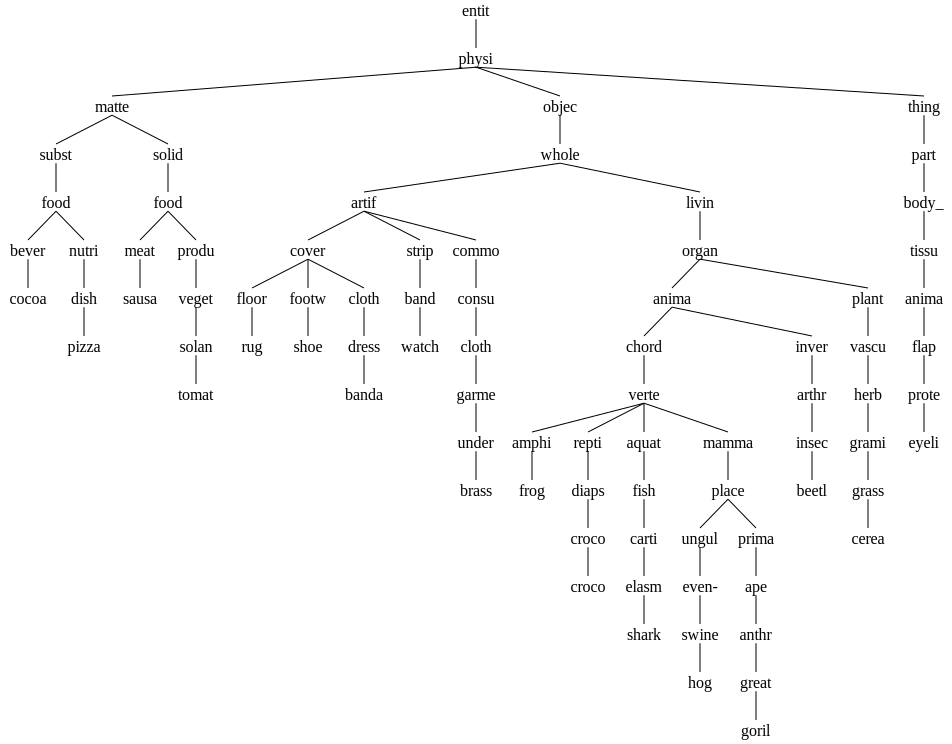

In [456]:
build_display_tree(abstraction_tree, wn.synset('entity.n.01'), char_limit=5)

In [540]:
abstraction_tree

,SYNSET,WORD,DIST2LEAF,NUM_LEAVES,HYPERNYM,HYPONYMS,EMBEDDING,POSITIVE,NEGATIVE,X_TRAIN,X_TEST,Y_TRAIN,Y_TEST,CLASSIFIER
SYNSET,,,,,,,,,,,,,,
Synset('crocodile.n.01'),Synset('crocodile.n.01'),crocodile,0,1,[Synset('crocodilian_reptile.n.01')],[],"[-0.018247928, -0.09612818, -0.028747449, -0.1...",[],[],[],[],[],[],None
Synset('gorilla.n.01'),Synset('gorilla.n.01'),gorilla,0,1,[Synset('great_ape.n.01')],[],"[0.013077118, 0.099059194, -0.09871134, -0.131...",[],[],[],[],[],[],None
Synset('bandage.n.01'),Synset('bandage.n.01'),bandage,0,1,[Synset('dressing.n.04')],[],"[-0.39212647, -0.09895855, -0.19498833, 0.1028...",[],[],[],[],[],[],None
Synset('pizza.n.01'),Synset('pizza.n.01'),pizza,0,1,[Synset('dish.n.02')],[],"[-0.008589342, 0.028149165, 0.07240878, 0.2433...",[],[],[],[],[],[],None
Synset('hog.n.03'),Synset('hog.n.03'),pig,0,1,[Synset('swine.n.01')],[],"[-0.019314175, -0.3430049, 0.027988998, -0.070...",[],[],[],[],[],[],None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Synset('body_part.n.01'),Synset('body_part.n.01'),None,5,1,[Synset('part.n.03')],[Synset('tissue.n.01')],None,[],[],[],[],[],[],None
Synset('entity.n.01'),Synset('entity.n.01'),None,15,17,[],[Synset('physical_entity.n.01')],"[-0.10602808155377733, -0.07651998449778649, -...","[Synset('cocoa.n.01'), Synset('dish.n.02'), Sy...","[Synset('eyelid.n.01'), Synset('watchband.n.01...","[Synset('chordate.n.01'), Synset('cocoa.n.01')...","[Synset('covering.n.02'), Synset('animal_tissu...","[0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0]",LogisticRegression()
Synset('living_thing.n.01'),Synset('living_thing.n.01'),None,11,7,[Synset('whole.n.02')],[Synset('organism.n.01')],"[-0.10602808155377733, -0.07651998449778649, -...","[Synset('frog.n.01'), Synset('crocodilian_rept...","[Synset('rug.n.01'), Synset('covering.n.02'), ...","[Synset('frog.n.01'), Synset('covering.n.02'),...","[Synset('bandage.n.01'), Synset('cereal.n.01')...","[1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 1.0, 0.0, 1.0]",LogisticRegression()
